In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import imutils

In [3]:
def shi_tomashi(image):
    """
    Use Shi-Tomashi algorithm to detect corners
    Args:
        image: np.array
    Returns:
        corners: list
    """
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    corners = cv2.goodFeaturesToTrack(gray, 4, 0.01, 100)
    corners = np.int0(corners)
    corners = sorted(np.concatenate(corners).tolist())
    print('\nThe corner points are...\n')

    im = image.copy()
    for index, c in enumerate(corners):
        x, y = c
        cv2.circle(im, (x, y), 3, 255, -1)
        character = chr(65 + index)
        print(character, ':', c)
        cv2.putText(im, character, tuple(c), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2, cv2.LINE_AA)

    plt.imshow(im)
    plt.title('Corner Detection: Shi-Tomashi')
    plt.show()
    return corners

In [2]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

<ipython-input-83-70f6f09ccf45>:44: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  cv2.circle(image, (x, y), 10, 255, -1)


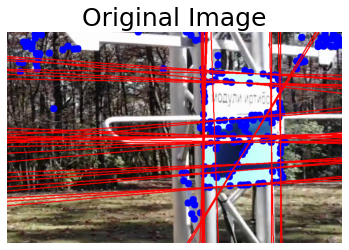

In [83]:
image = cv2.imread('mast_imgs/frame_25.jpg')
image = image[300:-200, 900:-100, :]

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

 
# Converting the image to hsv
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 
lower_blue = np.array([60,35,140])
upper_blue = np.array([190,255,255])
     
mask = cv2.inRange(hsv, lower_blue, upper_blue)
    
result = cv2.bitwise_and(image, image, mask = mask)

edges = cv2.Canny(result, 255/3, 255)

def lines():
    lines = cv2.HoughLines(edges, 1, np.pi/180, 60)
    for r_theta in lines:
        arr = np.array(r_theta[0], dtype=np.float64)
        r, theta = arr

        a = np.cos(theta)
        b = np.sin(theta)

        x0 = a*r
        y0 = b*r
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))

        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
def corners():
    corners = cv2.goodFeaturesToTrack(edges, 400, 0.1, 10)

    #print(corners)
    for i in corners:
        x, y = i.ravel()
        cv2.circle(image, (x, y), 10, 255, -1)

corners()
lines()
#plt.figure(figsize=[13,13])

#plt.subplot(141);
#plt.imshow(edged[:,:]);plt.title("Edged Image",fontdict={'fontsize': 25});plt.axis('off');
plt.imshow(image[:,:,::-1]);plt.title("Original Image",fontdict={'fontsize': 25});plt.axis('off');
#plt.subplot(142);
#plt.imshow(mask, cmap='gray');plt.title("Mask of blue Color",fontdict={'fontsize': 25});plt.axis('off');
#plt.subplot(143);
#plt.imshow(result[:,:,::-1]);plt.title("Result Image",fontdict={'fontsize': 25});plt.axis('off');
#plt.imshow(edges[:,:]);plt.title("Edged Image",fontdict={'fontsize': 25});plt.axis('off');


#plt.subplot(144),
#plt.imshow(edges,cmap = 'gray')




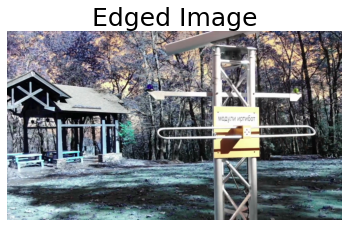

In [68]:
frame = cv2.imread('mast_imgs/frame_42.jpg')

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (7, 7), 0)
edged = cv2.Canny(blurred, 50, 150)
# find contours in the edge map
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

for c in cnts:
    # approximate the contour
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * peri, True)
    # ensure that the approximated contour is "roughly" rectangular
    if len(approx) >= 4 and len(approx) <= 6:
        # compute the bounding box of the approximated contour and
        # use the bounding box to compute the aspect ratio
        (x, y, w, h) = cv2.boundingRect(approx)
        aspectRatio = w / float(h)
        # compute the solidity of the original contour
        area = cv2.contourArea(c)
        hullArea = cv2.contourArea(cv2.convexHull(c))
        solidity = area / float(hullArea)
        # compute whether or not the width and height, solidity, and
        # aspect ratio of the contour falls within appropriate bounds
        keepDims = w > 25 and h > 25
        keepSolidity = solidity > 0.9
        keepAspectRatio = aspectRatio >= 0.8 and aspectRatio <= 1.2
        # ensure that the contour passes all our tests
        if keepDims and keepSolidity and keepAspectRatio:
            # draw an outline around the target and update the status
            # text
            cv2.drawContours(frame, [approx], -1, (0, 0, 255), 4)
            status = "Target(s) Acquired"
            # compute the center of the contour region and draw the
            # crosshairs
            M = cv2.moments(approx)
            (cX, cY) = (int(M["m10"] // M["m00"]), int(M["m01"] // M["m00"]))
            (startX, endX) = (int(cX - (w * 0.15)), int(cX + (w * 0.15)))
            (startY, endY) = (int(cY - (h * 0.15)), int(cY + (h * 0.15)))
            cv2.line(frame, (startX, cY), (endX, cY), (0, 0, 255), 3)
            cv2.line(frame, (cX, startY), (cX, endY), (0, 0, 255), 3)

plt.imshow(frame[:,:]);plt.title("Edged Image",fontdict={'fontsize': 25});plt.axis('off');